In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import lib_read_HiPSTAR as rf
import lib_VTK as vtk
import numpy as np
import matplotlib.pyplot as plt

# wake line

In [3]:
#alpha1 = np.arctan((-1.44001+1.72454)/(1.01424-1.11261))
alpha1 = np.arctan((-1.47673+1.68529)/(0.997596-1.06985))
print alpha1
alpha = np.rad2deg(alpha1)
print alpha

-1.23729448581
-70.8917520519


In [4]:
#set location of TE, and wake angle
x1=1.0
y1=-1.43
len_line=0.8  # length of line
np_line=600   #number of points on line
x2 = x1+0.2*np.cos(np.deg2rad(alpha))
y2 = y1+0.2*np.sin(np.deg2rad(alpha))
x3 = x1+1.0*np.cos(np.deg2rad(alpha))
y3 = y1+1.0*np.sin(np.deg2rad(alpha))
print x2,y2
print x3,y3
x = np.linspace(x2, x3)
y = np.linspace(y2, y3)
z = 0.0

1.06547078492 -1.61898035962
1.32735392462 -2.37490179809


# function

In [5]:
import numpy as np 

def xi_eta(stress):
    """
    stress is a numpy array of 6 components
    a11, a22, a33, a12, a13, a23
    """
    a11 = stress[0]
    a22 = stress[1]
    a33 = stress[2]
    a12 = stress[3]
    a13 = stress[4]
    a23 = stress[5]

    I1 = a11 + a22 + a33
    I2 = a11*a22 + a22*a33 + a11*a33 \
         -a12*a12 - a23*a23 - a13*a13
    I3 = -a13*a22*a13 + a12*a23*a13 + a13*a12*a23 \
         -a11*a23*a23 - a12*a12*a33 + a11*a22*a33

    xi = (I3/2.0)**(1.0/3.0)
    eta = (-0.5*I2)**0.5
    
    Is = np.asarray([xi,eta])
    return(Is)

def list_xi_eta(stresses):
    """
    stresses is a list of stress;
    stress is a numpy array of 6 components
    a11, a22, a33, a12, a13, a23
    """
    n = len(stresses)
    inv = []
    for i in range(n):
        inv.append(xi_eta(stresses[i]))
    inv = np.asarray(inv)
    return(inv)

def xi_eta_bound():

    p0 = [0.0, 0.0]
    p1 = [-1.0/6.0, 1.0/6.0]
    p2 = [1.0/3.0, 1.0/3.0]

    l1 = []
    l2 = []
    l3 = []

    x1 = np.linspace(p0[0], p2[0])
    x2 = np.linspace(p2[0], p1[0])
    x3 = np.linspace(p0[0], p1[0])

    y1 = x1
    y2 = (1.0/27.0 + 2.0*x2**3.0)**0.5
    y3 = -x3

    l1.append(x1)
    l1.append(y1)
    l2.append(x2)
    l2.append(y2)
    l3.append(x3)
    l3.append(y3)

    return(l1,l2,l3)

# Hip VTK

In [6]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
hip_vtk = vtk.read_VTK_dataset('vtk/LS5TI5.vtk')

In [7]:
#list the vars to be outputed
nvar_source = hip_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = hip_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

7
['$ \\overline{\\rho}$', '$ \\tau_{11}$', '$ \\tau_{12}$', '$ \\tau_{13}$', '$ \\tau_{22}$', '$ \\tau_{23}$', '$ \\tau_{33}$']


In [8]:
HiP_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(hip_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[0][1][0][0]
    Rxx = -data[1][1][0][0]
    Rxy = -data[2][1][0][0]
    Rxz = -data[3][1][0][0]
    Ryy = -data[4][1][0][0]
    Ryz = -data[5][1][0][0]
    Rzz = -data[6][1][0][0]
    
    tke = 0.5*(Rxx + Ryy + Rzz)

    HiP_stress_line.append(np.asarray([Rxx/2.0/tke-1.0/3.0,Ryy/2.0/tke-1.0/3.0,Rzz/2.0/tke-1.0/3.0,Rxy,Rxz,Ryz]))

In [9]:
HiP_inv_line = list_xi_eta(HiP_stress_line)
print HiP_inv_line.shape

(50, 2)


/home/yaomin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


# Lumley

In [10]:
l1,l2,l3 = xi_eta_bound()

# RANS Baseline

In [11]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
baseline_vtk = vtk.read_VTK_dataset('vtk/RANS_baseline.vtk')
#list the vars to be outputed
nvar_source = baseline_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = baseline_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

13
['Momentum', 'Density', 'Function0', 'Function1', 'Function2', 'Function3', 'Function4', 'Function5', 'Function6', 'Function7', 'Function8', 'Pressure', 'StagnationEnergy']


In [12]:
baseline_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(baseline_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[1][1][0][0]
    tke = data[9][1][0][0]
    Rxx = -data[2][1][0][0]/rho/tke/2.0
    Rxy = -data[3][1][0][0]/rho/tke/2.0
    Ryy = -data[4][1][0][0]/rho/tke/2.0
    Rxz = 0.0
    Ryz = 0.0
    Rzz = -(Rxx + Ryy)

    baseline_stress_line.append(np.asarray([Rxx,Ryy,Rzz,Rxy,Rxz,Ryz]))

In [13]:
baseline_inv_line = list_xi_eta(baseline_stress_line)
print baseline_inv_line.shape

(50, 2)


/home/yaomin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


# GEP Model

In [14]:
# read hipstar data into vtk object, need to output data into .vtk by paraview first!
inloop_vtk = vtk.read_VTK_dataset('vtk/RANS_inloop.vtk')
#list the vars to be outputed
nvar_source = inloop_vtk.GetPointData().GetNumberOfArrays()
print nvar_source
var_list = []
for i in range(nvar_source):
    temp_var = inloop_vtk.GetPointData().GetArrayName(i)
#    print i,temp_var
    var_list.append(temp_var)
#lines = [line.rstrip('\n') for line in open('vtk/header.txt')]
#print lines
print var_list

13
['Momentum', 'Density', 'Function0', 'Function1', 'Function2', 'Function3', 'Function4', 'Function5', 'Function6', 'Function7', 'Function8', 'Pressure', 'StagnationEnergy']


In [15]:
inloop_stress_line = []
for i in range(len(x)):
    pt = [x[i],y[i],z]
    _, data = vtk.extract_VTK_point(inloop_vtk,pt)

    # Hipstar uses negative stress convention
    rho = data[1][1][0][0]
    tke = data[9][1][0][0]
    tau_xx = -data[2][1][0][0]/rho/tke/2.0
    tau_xy = -data[3][1][0][0]/rho/tke/2.0
    tau_yy = -data[4][1][0][0]/rho/tke/2.0
    
    a_xx = data[6][1][0][0]/rho/tke/2.0
    a_xy = data[7][1][0][0]/rho/tke/2.0
    a_yy = data[8][1][0][0]/rho/tke/2.0
    
    Rxx = a_xx + tau_xx 
    Rxy = a_xy + tau_xy 
    Ryy = a_yy + tau_yy 
    #Rxx = tau_xx 
    #Rxy = tau_xy 
    #Ryy = tau_yy 
    Rxz = 0.0
    Ryz = 0.0
    Rzz = -(Rxx + Ryy)
    #Rzz = -(tau_xx + tau_yy)
    #print rho,tke,a_xx
    inloop_stress_line.append(np.asarray([Rxx,Ryy,Rzz,Rxy,Rxz,Ryz]))

In [16]:
inloop_inv_line = list_xi_eta(inloop_stress_line)
print inloop_inv_line.shape

(50, 2)


/home/yaomin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


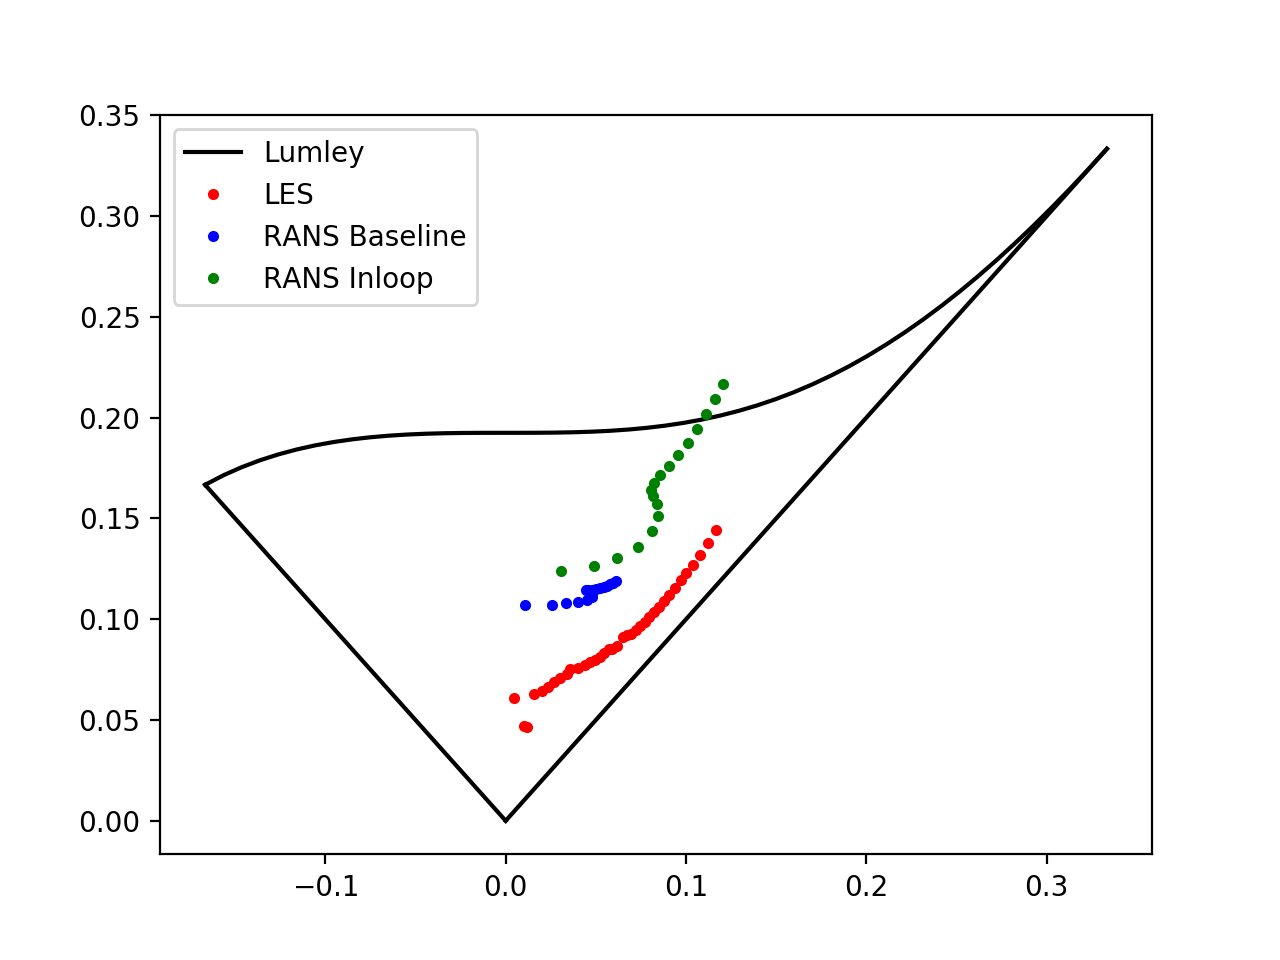

In [18]:
plt.figure()
#plt.axes(aspect='equal')
plt.plot(l1[0],l1[1],'k-',label='Lumley')
plt.plot(l2[0],l2[1],'k-')
plt.plot(l3[0],l3[1],'k-')
plt.plot(HiP_inv_line[:,0],HiP_inv_line[:,1],'ro',markersize=3,label='LES')
plt.plot(baseline_inv_line[:,0],baseline_inv_line[:,1],'bo',markersize=3,label='RANS Baseline')
plt.plot(inloop_inv_line[:,0],inloop_inv_line[:,1],'go',markersize=3,label='RANS Inloop')
#plt.xlim(-0.01,0.01)
plt.legend()
plt.show()